# RTF Model for predicting zone with Peaks - Vibrations

Import

In [ ]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

ReadCsv function

Colonnes du fichier P1_RB_1_C.matImpactN1.csv : (2401, 1)


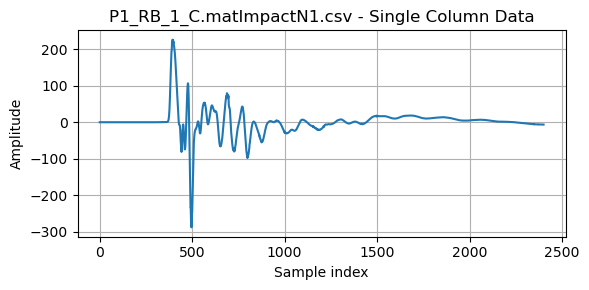

Colonnes du fichier P1_RB_1_C.matImpactN2.csv : (2401, 1)


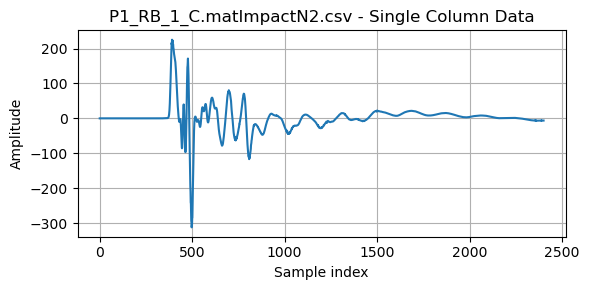

In [54]:
def readCsvFolder(folderPath):
    fileFolder = []
    files = []
    for filepath in glob.glob(os.path.join(folderPath, '*.csv')):
        try:
            data = pd.read_csv(filepath, header=None)  # On suppose pas d'en-têtes
            fileFolder.append(data)
            files.append(os.path.basename(filepath))
        except Exception as e:
            print(f"Erreur lors de la lecture de {filepath} : {e}")
    return fileFolder, files

# Lecture des fichiers
csv_data_list, filenames = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P1_clean/RB")

# Affichage
for i,csv_data in enumerate(csv_data_list[:2]):
    print(f"Colonnes du fichier {filenames[i]} :",csv_data.shape)

    plt.figure(figsize=(6, 3))
    if csv_data.shape[1] >= 2:
        time_axis = range(len(csv_data.iloc[:, 1]))  # Pas de vraie échelle de temps si on ne l'a pas
        plt.plot(time_axis, csv_data.iloc[:, 1], label="Amplitude")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
        plt.title(f"{filenames[i]} - Channel 1")
    else:
        plt.plot(csv_data.iloc[:, 0])
        plt.title(f"{filenames[i]} - Single Column Data")
        plt.xlabel("Sample index")
        plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Spectrum

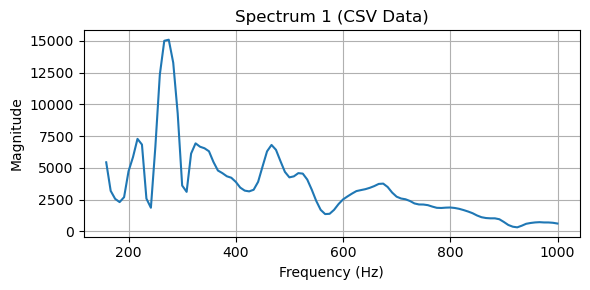

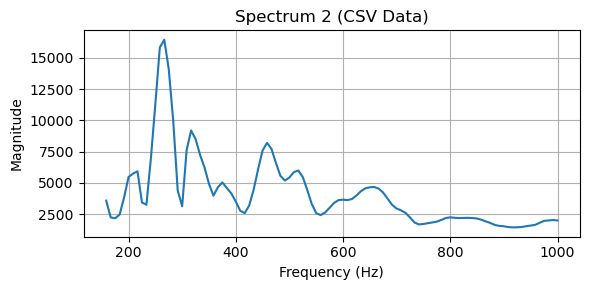

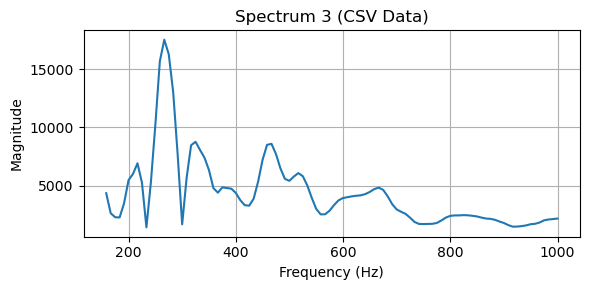

In [55]:
def spectrumFromCsv(csv_data, sample_rate):
    """Calcule le spectre à partir d'un signal CSV"""
    signal = csv_data.iloc[:, 0].values  # extrait la colonne souhaitée
    spectrum = fft(signal)
    magnitude = abs(spectrum[:len(spectrum) // 2])
    freqs = np.fft.fftfreq(len(signal), d=1/sample_rate)[:len(spectrum) // 2]
    return freqs, magnitude

sample_rate = 20000

spectrumVect = []

for csv_data in csv_data_list:
    freqs, spectrum = spectrumFromCsv(csv_data, sample_rate)
    # Filtrage de la bande [150 Hz, 1000 Hz]
    band_mask = (freqs >= 150) & (freqs <= 1000)
    filtered_freqs = freqs[band_mask]
    filtered_spectrum = spectrum[band_mask]
    spectrumVect.append((filtered_freqs, filtered_spectrum))


# Visualisation des spectres pour les données CSV
for idx, (freqs, spectrum) in enumerate(spectrumVect[:3]):
    plt.figure(figsize=(6, 3))
    plt.plot(freqs, spectrum)
    plt.title(f"Spectrum {idx + 1} (CSV Data)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Extract each peak and store

In [56]:
def extractNPeak(n_peak,signal):
    # Find peaks in the signal
    peaks = np.argsort(signal)[-n_peak:]  # Get indices of the n largest peaks
    peaks = np.sort(peaks)  # Sort the indices in ascending order

    # Extract the peak values
    peak_values = signal[peaks]

    return peaks, peak_values


# Fonction pour lire les fichiers d'un dossier donné
def lire_fichiers_dossier(dossier):
    if os.path.exists(dossier):  # Vérifier si le dossier existe
        return readCsvFolder(dossier)
    else:
        print(f"Dossier introuvable : {dossier}")
        return [], [], []  # Retourne des listes vides si le dossier n'existe pas


## Main

In [57]:
# Liste des types de raquettes et zones
raquetteTypeList = {"RB":0, "RO":1, "RR":2, "RV":3}
racket_ages = {"P1":1, "P2":2, "P3":3}

allCsvFile=[]
allCsvFileLabel=[]
allCsvFileP1=[]
allCsvFileP2=[]
allCsvFileP3=[]

for raquetteType in raquetteTypeList:
    #P1
    fileFolderP1,filesP1 = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P1_clean/"+raquetteType)
    allCsvFileP1.extend(fileFolderP1)

    #P2
    fileFolderP2,filesP2 = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P2_clean/"+raquetteType)
    allCsvFileP2.extend(fileFolderP1)

    #P3
    fileFolderP3,filesP3 = readCsvFolder("../../Data_Clean/Chanel0_Data_Columns/P3_clean/"+raquetteType)
    allCsvFileP3.extend(fileFolderP3)


# Find the minimum length among the three lists
min_len = min(len(allCsvFileP1), len(allCsvFileP2), len(allCsvFileP3))

# Reduce each list to the minimum length
allCsvFileP1 = allCsvFileP1[:min_len]
allCsvFileP2 = allCsvFileP2[:min_len]
allCsvFileP3 = allCsvFileP3[:min_len]

print("Len(allCsvFileP1)",len(allCsvFileP1),"Len(allCsvFileP2)",len(allCsvFileP2),"Len(allCsvFileP3)",len(allCsvFileP3))


# print(len(sampleRateFolderP1))

for csvFile in allCsvFileP1:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("P1")
for csvFile in allCsvFileP2:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("P2")
for csvFile in allCsvFileP3:
    allCsvFile.append(csvFile)
    allCsvFileLabel.append("P3")

Len(allCsvFileP1) 208 Len(allCsvFileP2) 208 Len(allCsvFileP3) 208


Extract peaks

In [58]:
bestPeakHZAllCsvFile = []
bestPeakAmplitudeAllCsvFile = []
n_peak = 25

for csvFile in allCsvFile:
    # Compute the spectrum using FFT
    freqs, spectrum = spectrumFromCsv(csvFile, sample_rate)

    # Extract peaks from the spectrum
    peaks_HZ, peak_Amplitude = extractNPeak(n_peak, spectrum)
    bestPeakHZAllCsvFile.append(peaks_HZ)
    bestPeakAmplitudeAllCsvFile.append(peak_Amplitude)

    # Normaliser les amplitudes
    bestPeakAmplitudeAllCsvFile = [amp / np.max(amp) for amp in bestPeakAmplitudeAllCsvFile]

In [59]:
# Combine features into X
X = np.hstack([np.array(bestPeakHZAllCsvFile), np.array(bestPeakAmplitudeAllCsvFile)])

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(allCsvFileLabel)

# Diviser les données en ensembles d'entraînement et de test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [60]:
# Définir les bonnes valeurs trouvé
n_estimators_range = [10, 50, 100]
max_depth_range = [None, 10, 20, 30]
min_samples_split_range = [2, 5, 10]

results = []

# Tester toutes les combinaisons d'hyperparamètres
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            rf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)
            y_train_pred = rf.predict(X_train)

            results.append({
                'n_estimators': n_estimators,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'accuracy_train': accuracy_score(y_train, y_train_pred),
                'accuracy_test': accuracy_score(y_test, y_pred)
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Enregistrer les résultats dans un fichier Excel
results_df.to_excel("RTF_AGE_P1.P2.P3_Peaks.xlsx", index=False)

print("Results have been saved to 'RTF_AGE_P1.P2.P3_Peaks.xlsx'.")

# Trier les résultats par ordre décroissant de 'accuracy_test'
sorted_results_df = results_df.sort_values(by='accuracy_test', ascending=False)

# Afficher les résultats triés
print(sorted_results_df)

Results have been saved to 'RTF_AGE_P1.P2.P3_Peaks.xlsx'.
    n_estimators  max_depth  min_samples_split  accuracy_train  accuracy_test
3             10       10.0                  2        0.703407          0.520
4             10       10.0                  5        0.707415          0.504
5             10       10.0                 10        0.707415          0.504
0             10        NaN                  2        0.709419          0.496
9             10       30.0                  2        0.709419          0.496
15            50       10.0                  2        0.709419          0.496
11            10       30.0                 10        0.709419          0.496
10            10       30.0                  5        0.709419          0.496
8             10       20.0                 10        0.709419          0.496
1             10        NaN                  5        0.709419          0.496
7             10       20.0                  5        0.709419          0.496
6     

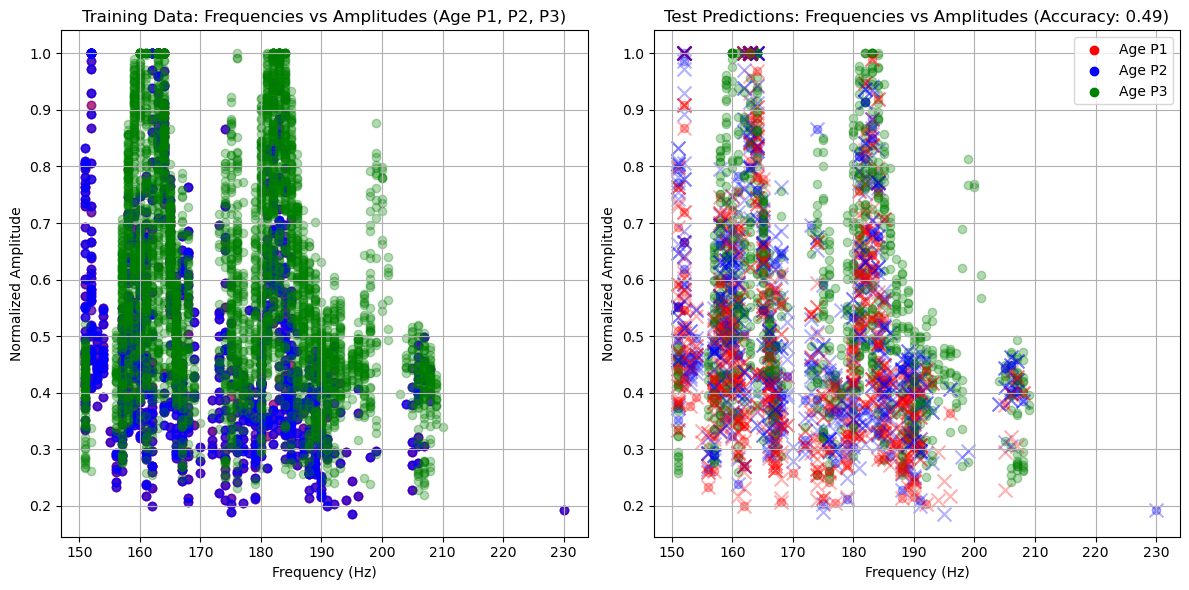

In [61]:
# Define a color map for the labels
colors = ['red', 'blue', 'green']
ageList = {"P1": 1, "P2": 2, "P3": 3}
label_names = list(ageList.keys())

# Create a scatter plot for the training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # First subplot for training data
for label_idx, label_name in enumerate(label_names):
    # Filter data points for the current label
    label_data = X_train[y_train == label_idx]
    for sample in label_data:
        # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
        frequencies = sample[:n_peak] + 150
        amplitudes = sample[n_peak:]
        mask = frequencies <= 550
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[label_idx], alpha=0.3)

plt.title("Training Data: Frequencies vs Amplitudes (Age P1, P2, P3)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

# Create a scatter plot for the test data with predictions
plt.subplot(1, 2, 2) # Second subplot for test data with predictions
y_pred = rf.predict(X_test) # Get predictions for test data

for i, sample in enumerate(X_test):
    true_label = y_test[i]
    pred_label = y_pred[i]

    # Add 150Hz because of the filter and filter frequencies <= 1250 Hz
    frequencies = sample[:n_peak] + 150
    amplitudes = sample[n_peak:]
    mask = frequencies <= 550

    # Plot with solid color if prediction is correct, otherwise use a different marker
    if true_label == pred_label:
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], alpha=0.3)
    else:
        # Use 'x' marker for incorrect predictions
        plt.scatter(frequencies[mask], amplitudes[mask], color=colors[pred_label], marker='x', s=100, alpha=0.3)

# Add a legend
for label_idx, label_name in enumerate(label_names):
    plt.scatter([], [], color=colors[label_idx], label=f"Age {label_name}")

plt.legend()
plt.title(f"Test Predictions: Frequencies vs Amplitudes (Accuracy: {accuracy_score(y_test, y_pred):.2f})")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

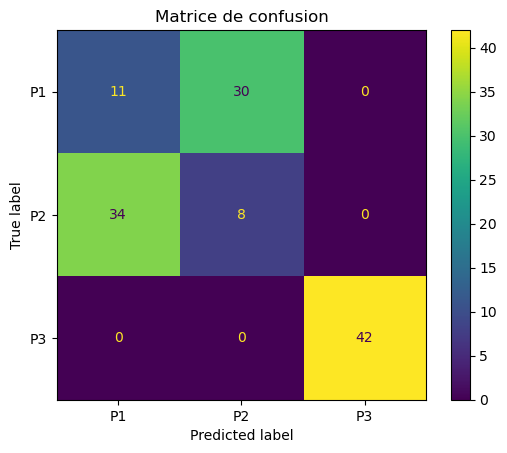

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

# Afficher la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.title("Matrice de confusion")
plt.show()